# DENSITY PEAKS ALGORYTHM

In [97]:
import numpy as np
from typing import NamedTuple, Tuple
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Arc
import pandas as pd
from numba import njit,jit, config #High performance JIT compiler and parallelization libraries

In [21]:
X_data = np.loadtxt("Aggregation.txt")
X_data = X_data[:,[0,1]]
S3_data = np.loadtxt("s3.txt")

In [22]:
def local_density(X: np.ndarray, kind, dc):
    """
    Compute all points's local density.
    Args: X: data
    Kind: True if gaussian init or False for exact initialization
    dc= free parameter for distance threshold
    returns: local density vector
             distance matrix
    """
    n,d = X.shape
    rho_vector = np.zeros(n)
    distances = np.zeros((n,n))
    
    rho_func = lambda dij, dc: np.exp(- (dij / dc) ** 2)
    cutoff_func = lambda dij, dc: 1 if dij < dc else 0
    func = rho_func if kind else cutoff_func
        
    for i in range(n):
        for j in range(i + 1, n):
            distance = np.sqrt(((X[i,:] - X[j,:])**2).sum(axis=0)) 
            distances[i, j] = distance
            distances[j, i] = distance
        
    for i in range(n):
        for j in range(i+1,n):
            temp = func(distances[i, j], dc)
            rho_vector[i] += temp
            rho_vector[j] += temp
            
    return rho_vector, distances

In [23]:
def delta_and_distance(X: np.ndarray, distances, rho):
    """
    Compute all points's min with respect to the higher local density point(delta distance).
    X: data
    distaneces: Matrix containing the distances between points
    rho : vector contaning local density
    :return: delta distance vector, nearest neighbor vector
    """
    
    n,_ = X.shape
    sorted_rho = np.argsort(-rho)
    delta = np.zeros(n)
    near_neigh = np.zeros(n)
    
    # For the point which has the higher density 
    delta[sorted_rho[0]] = distances[sorted_rho[0],:].max()
    max_dat = distances[sorted_rho[0],[i for i, x in enumerate(distances[sorted_rho[0],:]) if x.any()]]
    near_neigh[sorted_rho[0]] = sorted_rho[0]

    #For the rest
    for i in range(1,n):
        min_delta= distances[sorted_rho[i],sorted_rho[0]]
        near_neigh[sorted_rho[i]] = sorted_rho[0]
        for j in range(2,i+1):
            if i == j:
                continue
            _delta= distances[sorted_rho[i],sorted_rho[j]]
            if _delta<min_delta:
                min_delta = _delta
                near_neigh[sorted_rho[i]] = sorted_rho[j]
        
        delta[sorted_rho[i]]= min_delta
            
    return delta, near_neigh

In [289]:
def decision_plot_cluster_assignment(X: np.ndarray, kind, dc, gamma):
    """
    Plots the decision plot which has the points that will be the cluster centers
    ARgs: X: data
    Kind: True if gaussian init or False for exact initialization
    dc= free parameter for distance threshold
    gamma: free parameter for cluster selection
    return: centers of the cluster
            vector of cluster assignation
            labels for clusters
    """
    
    rho , distances = local_density(X,kind,dc)
    delta, near_n= delta_and_distance(X,distances,rho)
    
    n, d = X.shape
    plt.scatter(rho,delta)
#    plt.plot(rho,gamma/rho)
    plt.plot(rho,[dc]*n, 'r')

    centers = np.zeros((n,d))
    cluster = np.zeros(n)
    labels = np.zeros(n)
    count= 0
    for idx, delta_val in enumerate(delta):
    
        if delta_val >= dc and delta_val*rho[idx] >= gamma:
            cluster[idx] = count
            labels[idx] = count
            centers[idx] = X[idx]
            count = count +1
        else:
            cluster[idx] = -1
        
    centers = centers[[i for i, x in enumerate(centers) if x.any()]]
    labels = labels[[i for i, x in enumerate(labels) if x.any()]]
    
    # assignation
    sorted_rho = np.argsort(-rho)
    for i in range(sorted_rho.shape[0]):
        if cluster[sorted_rho[i]] == -1:
            cluster[sorted_rho[i]] = cluster[int(near_n[sorted_rho[i]])]
            
    return centers, cluster, labels

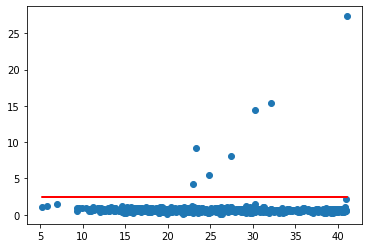

In [290]:
#applied to set Aggregation data
centers , cluster, labels= decision_plot_cluster_assignment(X_data, True, 2.5, 50)

In [291]:
def plot_DP(X, cluster , title=""):
    """
    Plot cluster.
    
    :param X: data
            title: title to plot
           cluster : vector contaning the cluster assignation
    :return: None
    """

    title_ = "Cluster assignation using Density Peaks" if title == "" else title
    plt.scatter(X[:,0], X[:,1], c=cluster)
    plt.title(title_)

    plt.show()

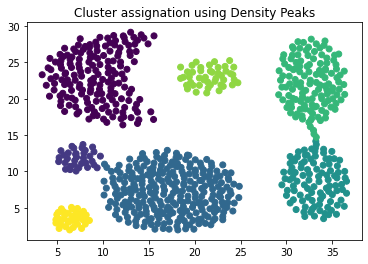

In [292]:
plot_DP(X_data, cluster)

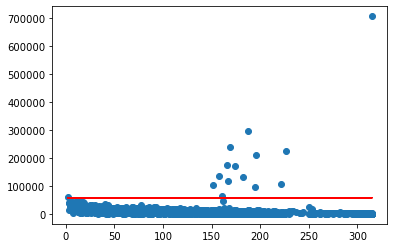

In [39]:
#applied to s3 data
centers_s3 , cluster_s3, labels_s3= decision_plot_cluster_assignment(S3_data, True, 57500, 57500*8)

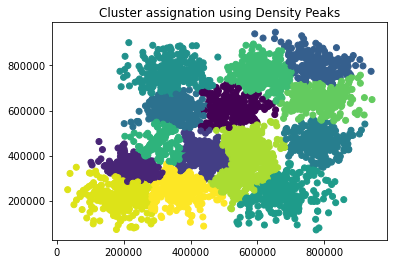

In [40]:
plot_DP(S3_data, cluster_s3)

In [187]:
# K-means

class Mixture(NamedTuple):
    """Tuple holding a mixture"""
    mu: np.ndarray  # (K, d) array - each row corresponds mean
    var: np.ndarray  # (K, ) array - corresponds to the variance
    p: np.ndarray  # (K, ) array = each row corresponds to the weight of a component
        
def init(X: np.ndarray, K: int, seed: int = 0, mode : str = "Classic" ) -> Tuple[Mixture, np.ndarray]:
    """Initializes the model 

    Args:
        X: (n, d) array holding the data
        K: number of components
        seed: random seed
        mode: Classic: Random init or K++: Kmeans ++
    Returns:
        mixture: the initialized mixture
        post: (n, K) array holding the counts for all points

    """
    np.random.seed(seed)
    n, d = X.shape
    p = np.ones(K) / K
    mu = np.zeros((K,d))
    weights= np.ones(n)
    
    # select K random points as initial means
    if mode in ["Classic"]:
        mu = X[np.random.choice(n, K, replace=False)]
        #print(mu)
    
    # K-means ++
    if mode in ["K++"]:
        for k in range(1,K+1):
            weights = weights / weights.sum()
            mu[k-1,:] = X[np.random.choice(n,1, p=weights)]
            for i in range(n):
                tiled_vector = np.tile(X[i, :], (k, 1))
                mu_vector = mu[0:k,:]
                sse = ((tiled_vector - mu_vector)**2).sum(axis=1)
                j = np.argmin(sse)
                weights[i] = sse[j]

    var = np.zeros(K)
    # Compute variance
    for j in range(K):
        var[j] = ((X - mu[j])**2).mean()

    mixture = Mixture(mu, var, p)
    # Matrix containing the cluster association
    post = np.ones((n, K))

    return mixture, post

def KMeans(X: np.ndarray, mixture: Mixture) -> np.ndarray:
    """Performs Clustering using KMeans method

    Args:
        X: (n, d) array holding the data
        mixture: holds the means, var and weights

    Returns:
        mixture: the updateded mixture
        post: (n, K) array holding the counts for all points
        cost = current cost of the step

        """
    n, d = X.shape
    K, _ = mixture.mu.shape
    post = np.zeros((n, K))

    for i in range(n):
        tiled_vector = np.tile(X[i, :], (K, 1))
        sse = ((tiled_vector - mixture.mu)**2).sum(axis=1)
        j = np.argmin(sse)
        post[i, j] = 1
    
    n_hat = post.sum(axis=0)
    p = n_hat / n

    cost = 0
    mu = np.zeros((K, d))
    var = np.zeros(K)

    for j in range(K):
        mu[j, :] = post[:, j] @ X / n_hat[j]
        sse = ((mu[j] - X)**2).sum(axis=1) @ post[:, j]
        cost += sse
        var[j] = sse / (d * n_hat[j])

    return Mixture(mu, var, p), cost , post

In [188]:
def plot(X: np.ndarray, mixture: Mixture, post: np.ndarray,
         title: str):
    """Plots 2D data"""
    _, K = post.shape

    percent = post / post.sum(axis=1).reshape(-1, 1)
    fig, ax = plt.subplots()
    ax.title.set_text(title)
    color = ["r", "b", "k", "y", "m", "c","g","r", "b", "k", "y", "m", "c","g","r"]
    
    cluster_association = np.zeros(post.shape[0])
    for i in range(post.shape[0]):
        cluster_association[i] = np.argmax(post[i,:])

    ax.scatter(X[:,0], X[:,1], c=cluster_association)
    for j in range(K):
        mu_ = mixture.mu[j]
        circle = Circle(mu_, np.sqrt(mixture.var[j]), color=color[j], fill=False)
        ax.add_patch(circle)
        legend = "mu_{:d} = ( {:0.3f}, {:0.3f})\n".format(j,mu_[0], mu_[1])
        ax.text(mu_[0], mu_[1], legend)
    
    plt.show()


def run(X: np.ndarray, mixture: Mixture,
        post: np.ndarray, method : str = "KMeans" ) -> Tuple[Mixture, np.ndarray, float]:
    """Runs the model choosing between -KMeans or Kmedoid

    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the counts for all points

    Returns:
        Mixture: the new mixture
        post np.ndarray: (n, K) array holding the counts for all points
        float: cost of the current assignment
    """

    prev_cost = None
    cost = None
    if method in ["KMeans"]:
        while (prev_cost is None or prev_cost - cost > 1e-4):
            prev_cost = cost
            mixture, cost , post= KMeans(X, mixture)
            
    if method in ["KMedoids"]:
        while (prev_cost is None or prev_cost - cost > 1e-4):
            prev_cost = cost
            mixture, cost , post= KMedoids(X, mixture)
    return mixture, post, cost

In [224]:
#@njit
def test_methods(X_data , initialization: str = "Classic", method : str = "KMeans", n : int= 15):
    #iterable around different number of clusters
    for K in range(n,n+1):
        min_cost = None
        best_seed = None
        for seed in range(0, 10):
            mixture, post = init(X_data, K, seed)
            mixture, post, cost = run(X_data, mixture, post)
            if min_cost is None or cost < min_cost:
                min_cost = cost
                best_seed = seed 
        mixture, post = init(X_data, K, best_seed,initialization)
        mixture, post, cost = run(X_data, mixture, post,method)
        print("Your cost using best seed:",format(min_cost,'.1E'))
        plot(X_data, mixture, post, initialization+method)
    return mixture, post, cost

Your cost using best seed: 1.1E+04


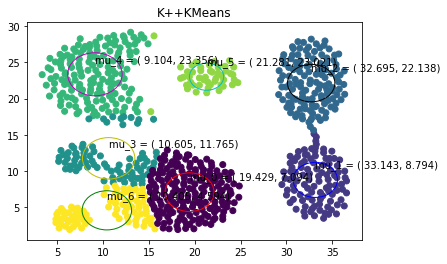

In [225]:
# running K-means with 7 cluster centers
mixture, post, cost = test_methods(X_data, "K++","KMeans",7)

In [226]:
n, k = post.shape
cluster_KMeans = np.zeros(n)
labels_KMeans= np.arange(k)
for i in range(n):
    cluster_KMeans[i] = post[i,:].argmax()

In [227]:
def F_ratio_test(X, cluster, labels, centers):
    """
    F ratio test for comparing clustering
    :param X: data
           cluster : vector contaning the cluster assignation
           labels: vector containing cluster labeling
           centers: vector containig the cluster centers
    :return: F VALUE
    """
    n , _ = X.shape
    k = labels.shape[0]
    X_mean = np.mean(X, axis=0)
    
    SSW = 0
    SSB = 0
    
    for i in range(k):
        for j in range(n):
            if int(cluster[j]) == int(labels[i]):
                dist = ((X[j,:] - centers[i,:])**2).sum()
                SSW = SSW + dist
    
    for j in range(k):
        n_j = np.count_nonzero(cluster == labels[j])
        inter_distance = ((centers[j] - X_mean)**2).sum()
        SSB = SSB + n_j*inter_distance
    
    F = k*SSW/SSB
    return F

In [228]:
#F test for DENSITY PEAKS
F_ratio_test(X_data,cluster,labels,centers)

0.8639409727670929

In [229]:
#F test for KMEANS
F_ratio_test(X_data,cluster_KMeans,labels_KMeans,mixture.mu)

0.6679428446312462

## According to F ratio test, the density peaks algorithm is the best for clustering the Agreggation dataset

# Normalized mutual information test

In [295]:
def normalized_mutual_information_test(X : pd.DataFrame, cluster_assignation: np.array):
    X["c_a"]= cluster_assignation.tolist()
    total=np.shape(X)[0]
    
    prob_assignation=X[["x","c_a"]].groupby(["c_a"]).agg(p_a=('c_a',pd.Series.count)).reset_index()
    prob_assignation=prob_assignation["p_a"]/total
    p_i=prob_assignation.values
    
    prob_sol=X[["x","sol"]].groupby(["sol"]).agg(p_s=('sol',pd.Series.count)).reset_index()
    prob_sol=prob_sol["p_s"]/total
    p_j=prob_sol.values
    
    p_ij=np.zeros((p_j.shape[0],p_j.shape[0])).astype(int)
    grouping=X.groupby(["c_a","sol"]).agg(n=("x",pd.Series.count)).reset_index().to_numpy()
    
    for i in range(grouping.shape[0]):
        p_ij[int(grouping[i,0]),int(grouping[i,1])-1] = grouping[i,2]
        
    p_ij=p_ij/total
    
    MI=0
    for i in range(p_j.shape[0]):
        for j in range(p_j.shape[0]):
            if p_ij[i,j]!=0.:
                MI += p_ij[i,j]*np.log(p_ij[i,j]/(p_i[i]*p_j[j]))
            
    H_K = - (p_i * np.log(p_i)).sum() 
    H_G = - (p_j * np.log(p_j)).sum() 

    NMI=2*MI/(H_K+H_G)
    return NMI

In [296]:
agregation_df = pd.read_csv("Aggregation.txt",sep="\t", names=["x","y","sol"])

In [299]:
#Normalized mutual information for density peaks
nmi_DP= normalized_mutual_information_test(agregation_df,cluster)
nmi_DP

1.0000000000000002

In [300]:
#Normalized mutual information for KMeans
nmi_KM= normalized_mutual_information_test(agregation_df,cluster_KMeans)
nmi_KM

0.8402590817965031